<a href="https://colab.research.google.com/github/enino84/Data-Assimilation-202210/blob/main/DA_01032022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasts and Numerical Models - Performing Data Assimilation

Duffing Equation

\begin{eqnarray}
x''+\delta x' + \alpha x +\beta x^3= \gamma \cos(\omega t)
\end{eqnarray}

this is equivalent to

\begin{eqnarray}
x''=-\delta x' - \alpha x -\beta x^3+ \gamma \cos(\omega t)
\end{eqnarray}

https://numpy.org/

In [ ]:
import numpy as np

In [ ]:
#(alpha, beta, delta, gamma, omega)
def f(x, t, args=(1, 5, 0.02, 8, 0.65)):
  alpha = args[0];
  beta = args[1];
  delta = args[2];
  gamma = args[3];
  omega = args[4];
  return (x[1], -delta*x[1] - alpha*x[0] - beta * x[0]**3 + gamma * np.cos(omega * t))

In [ ]:
from scipy.integrate import odeint

Initial condition $x'(0) = 1$ and $x(0) = 0$, $t \in [0,\, 200]$, and the sample size equals 200

1. Creando la trayectoria de referencia.
2. Creando el background inicial

In [ ]:
np.random.seed(10)

x0  = np.array([0, 1], dtype=np.float32);
t   = np.linspace(0,50, 3000);

xr  = odeint(f, x0, t); #reference trajectory

xb0 = x0 + np.random.randn(2,)

xb0 = odeint(f, xb0, t[:50])[-1,:]; #initial background



Reference Trajectory

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

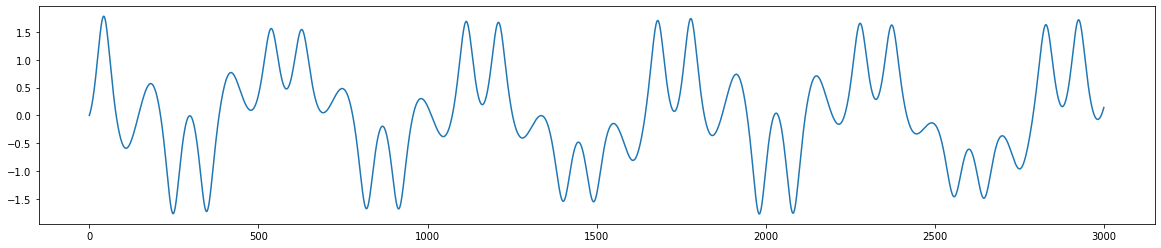

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(xr[:,0])

3. Generando el ensemble inicial

In [ ]:
x_samples = [];
samples = 200;
for i in range(0, samples):
  xi = xb0 + 0.1*np.random.randn(2,); #perturbation ~ 0.1
  xs = odeint(f, xi, t[50:100])[-1,:];
  x_samples.append(xs);
Xb = np.array(x_samples, dtype=np.float32).T;
Xb0 = Xb;

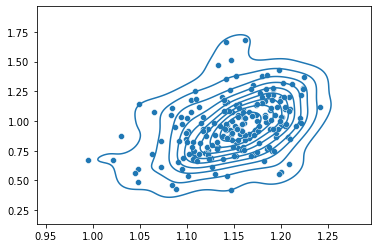

In [ ]:
sns.kdeplot(x=Xb[0,:], y=Xb[1,:])
sns.scatterplot(x=Xb[0,:], y=Xb[1,:])

In [ ]:
Pb = np.cov(Xb);

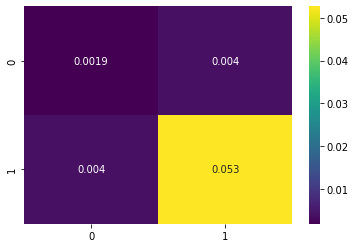

In [ ]:
sns.heatmap(Pb, annot=True, cmap='viridis')

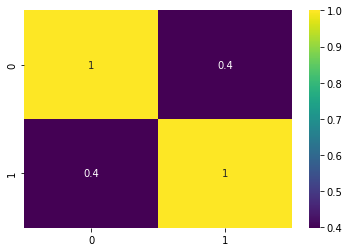

In [ ]:
Cb = np.corrcoef(Xb);
sns.heatmap(Cb, annot=True, cmap='viridis')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


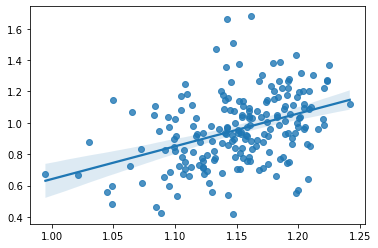

In [ ]:
sns.regplot(Xb[0,:],Xb[1,:])

4. Assimilation Steps

In [ ]:
def assimilation_enkf(Xb, R_inv, y):
  Ys = y + errobs*np.random.randn(samples, 2);
  Ys = Ys.T;
  Pb = np.cov(Xb);
  Pb_inv = np.linalg.inv(Pb);
  Pa_inv = Pb_inv + R_inv;
  rhs    = Pb_inv@Xb + R_inv@Ys;
  Xa = np.linalg.solve(Pa_inv, rhs);
  return Xa;

def perform_forecast(Xa, t, k):
  x_samples = [];
  for i in range(0, samples):
    xi = Xa[:,i]
    xs = odeint(f, xi, t[(k*100):((k+1)*100)])[-1,:];
    x_samples.append(xs);
  Xb = np.array(x_samples, dtype=np.float32).T;
  return Xb


In [ ]:
t

array([0.00000000e+00, 1.66722241e-02, 3.33444481e-02, ...,
       4.99666556e+01, 4.99833278e+01, 5.00000000e+01])

In [ ]:
errobs = 0.05;
k = 1;
Xb = Xb0
R = (errobs)**2*np.eye(2);
R_inv = (1/(errobs)**2)*np.eye(2);

M = 29;
errb = [];
erra = [];
Xbk  = [];
Xak  = [];
Xrk  = [];
Tk   = [];
for k in range(1, M):
  Tk.append(t[100*k])
  y = xr[100*k,:] + errobs*np.random.randn(2,); #This is what we have
  errb.append(np.linalg.norm(xr[100*k,:] - np.mean(Xb, axis=1)))
  Xa = assimilation_enkf(Xb, R_inv, y);
  Xak.append(Xa);
  erra.append(np.linalg.norm(xr[100*k,:] - np.mean(Xa, axis=1)))
  Xb = perform_forecast(Xa, t, k);
  Xbk.append(Xb);
  Xrk.append(xr[100*k,:]);
errb = np.array(errb, dtype=np.float32);
erra = np.array(erra, dtype=np.float32);
Tk   = np.array(Tk,   dtype=np.float32);
Xrk  = np.array(Xrk,  dtype=np.float32);

In [ ]:
Tk.shape

(28,)

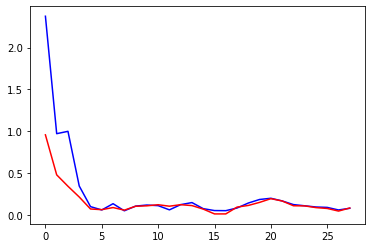

In [ ]:
plt.plot(errb, '-b');
plt.plot(erra, '-r');

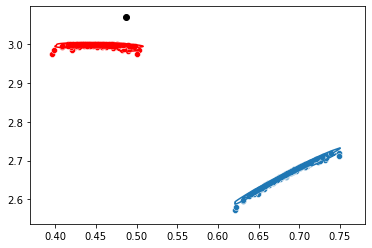

In [ ]:
sns.kdeplot(x=Xb[0,:], y=Xb[1,:])
sns.scatterplot(x=Xb[0,:], y=Xb[1,:])

sns.kdeplot(x=Xa[0,:], y=Xa[1,:], color='red')
sns.scatterplot(x=Xa[0,:], y=Xa[1,:], color='red')

plt.plot(xr[100*k,:][0], xr[100*k,:][1], 'ok', )

In [ ]:
all_data = np.empty((1,3))
for k in range(0, M-1):
  data = np.column_stack((Xak[k].T, np.array([Tk[k]]*samples).reshape(-1,1)));
  all_data = np.vstack((all_data, data));

In [ ]:
all_data = all_data[1:,:]

In [ ]:
import pandas as pd

In [ ]:
df_data = pd.DataFrame(all_data)

In [ ]:
df_data.columns=['x(t)','x\'(t)','t']

In [ ]:
df_data

,x(t),x'(t),t
0,0.399102,-0.649230,1.667222
1,0.426909,-0.672457,1.667222
2,0.402699,-0.714422,1.667222
3,0.417069,-0.705791,1.667222
4,0.378500,-0.631936,1.667222
...,...,...,...
5595,0.448436,3.000103,46.682228
5596,0.452855,3.000473,46.682228
5597,0.469352,3.000078,46.682228
5598,0.434739,3.000256,46.682228


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text major ticklabel objects>)

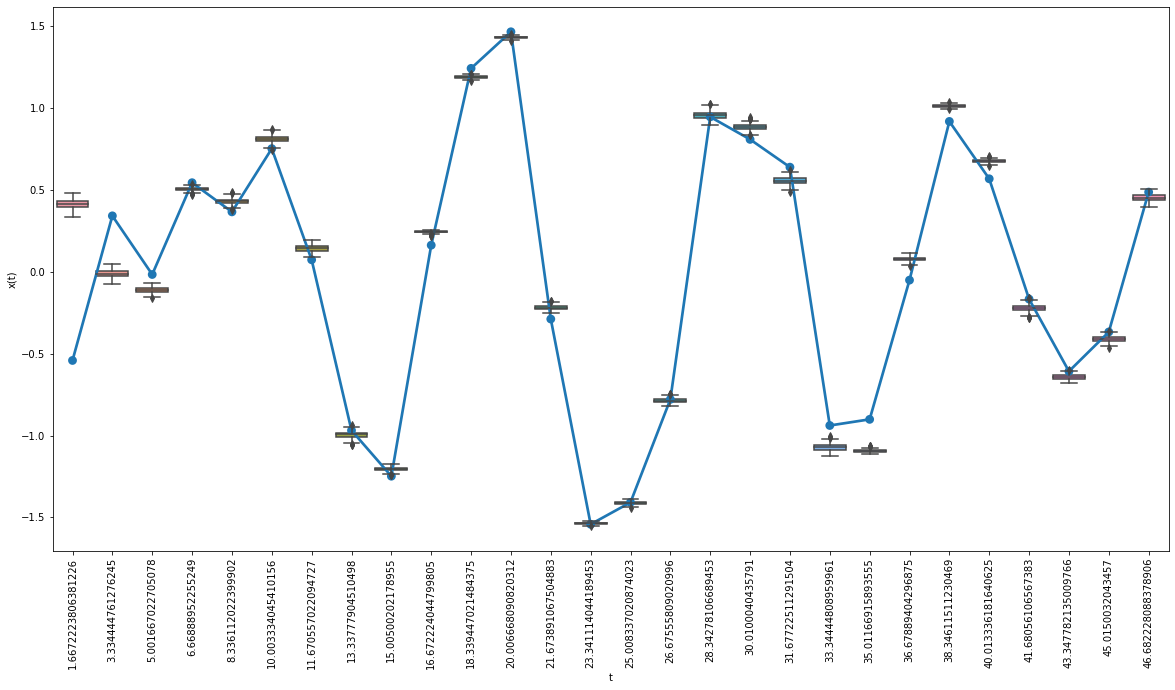

In [ ]:
plt.figure(figsize=(20,10))
sns.pointplot(x=Tk,y=Xrk[:,0])
sns.boxplot(data=df_data[['t', 'x(t)']], x='t', y='x(t)')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text major ticklabel objects>)

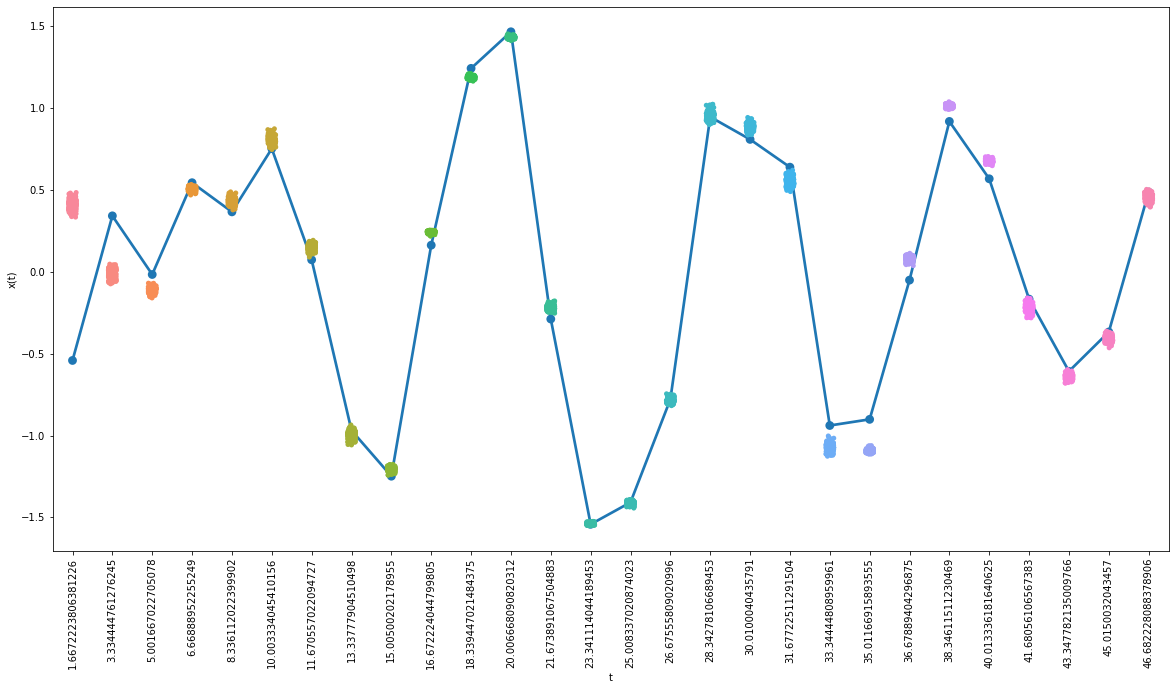

In [ ]:
plt.figure(figsize=(20,10))
sns.pointplot(x=Tk,y=Xrk[:,0])
sns.stripplot(data=df_data[['t', 'x(t)']], x='t', y='x(t)')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text major ticklabel objects>)

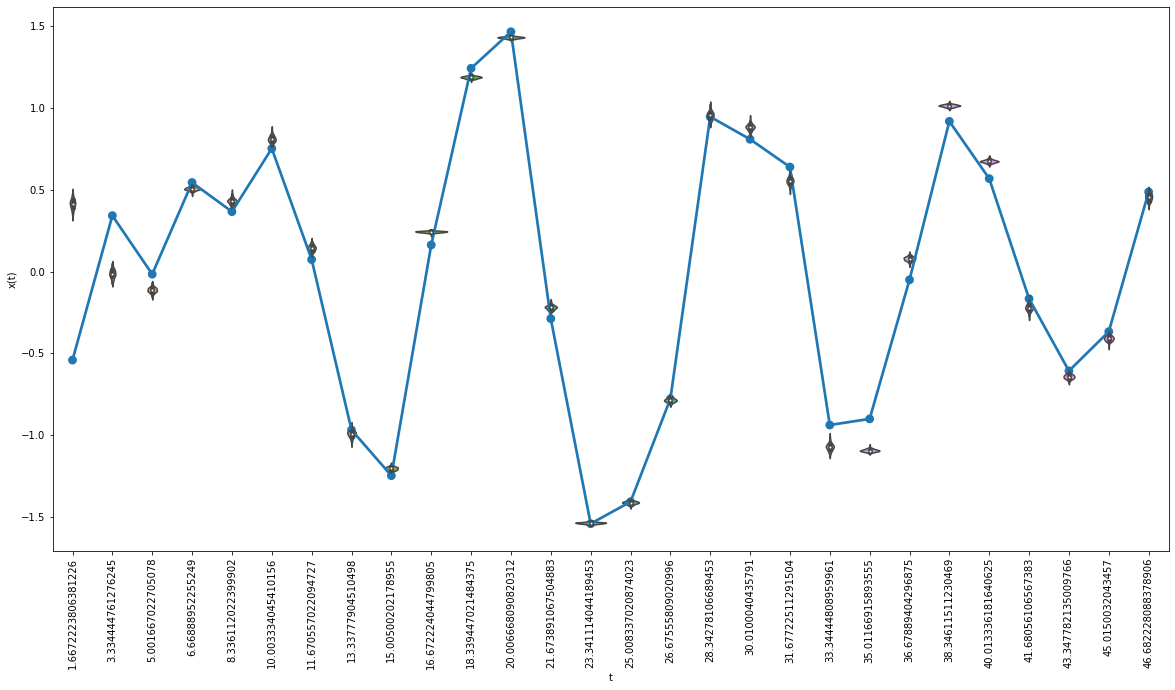

In [ ]:
plt.figure(figsize=(20,10))
sns.pointplot(x=Tk,y=Xrk[:,0])
sns.violinplot(data=df_data[['t', 'x(t)']], x='t', y='x(t)')
plt.xticks(rotation=90)

In [ ]:
xr[:,0]

array([0.        , 0.01778036, 0.03777297, ..., 0.09836865, 0.11903995,
       0.14073002])

In [ ]:
all_data = np.empty((1,4))
for k in range(0, M-1):
  data = np.column_stack((Xak[k].T, np.array([Tk[k]]*samples).reshape(-1,1), 
                          np.array(['Analysis']*samples).reshape(-1,1)));
  all_data = np.vstack((all_data, data));
  data = np.column_stack((Xbk[k].T, np.array([Tk[k]]*samples).reshape(-1,1), 
                          np.array(['Background']*samples).reshape(-1,1)));
  all_data = np.vstack((all_data, data));

  all_data = all_data[1:,:]

df_data = pd.DataFrame(all_data);
df_data.columns=['x(t)','x\'(t)','t','Step']
df_data['x(t)'] = df_data['x(t)'].astype(np.float32)
df_data['t'] = df_data['t'].astype(np.float32)
df_data['x\'(t)'] = df_data['x\'(t)'].astype(np.float32)

In [ ]:
df_data

,x(t),x'(t),t,Step
0,0.352776,-0.734777,1.667222,Analysis
1,0.408530,-0.691049,1.667222,Analysis
2,0.444026,-0.703773,1.667222,Analysis
3,0.365523,-0.651729,1.667222,Analysis
4,0.409320,-0.751519,1.667222,Analysis
...,...,...,...,...
11168,0.677466,2.657872,46.682228,Background
11169,0.682670,2.664043,46.682228,Background
11170,0.702668,2.685721,46.682228,Background
11171,0.660852,2.638831,46.682228,Background


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text major ticklabel objects>)

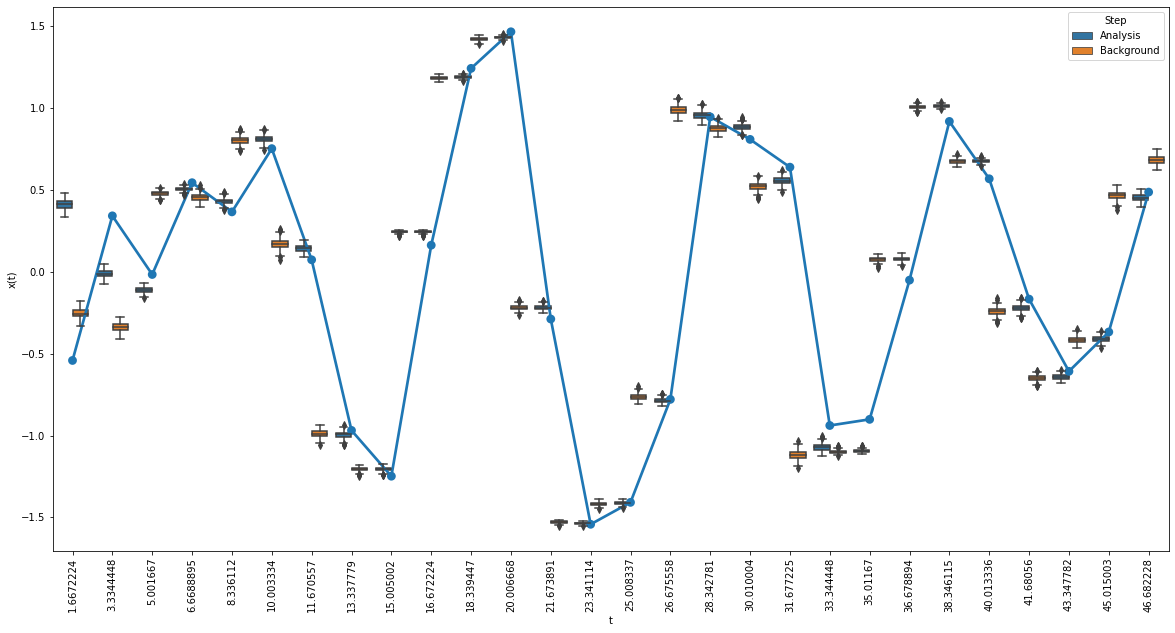

In [ ]:
plt.figure(figsize=(20,10))
sns.pointplot(x=Tk,y=Xrk[:,0])
sns.boxplot(data=df_data[['t', 'x(t)', 'Step']], x='t', y='x(t)', hue='Step')
plt.xticks(rotation=90)

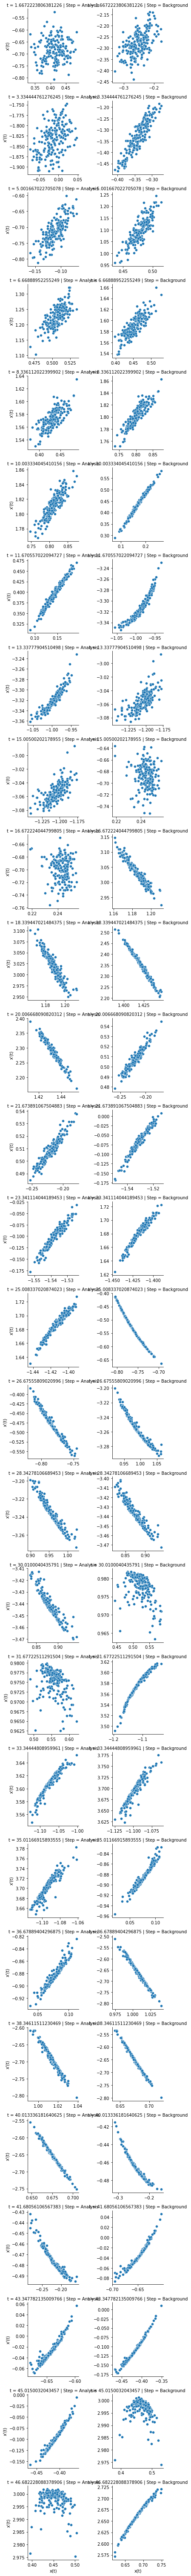

In [ ]:
g = sns.FacetGrid(df_data, col="Step",  row="t", sharex=False, sharey=False)
g.map(sns.scatterplot, 'x(t)', 'x\'(t)')

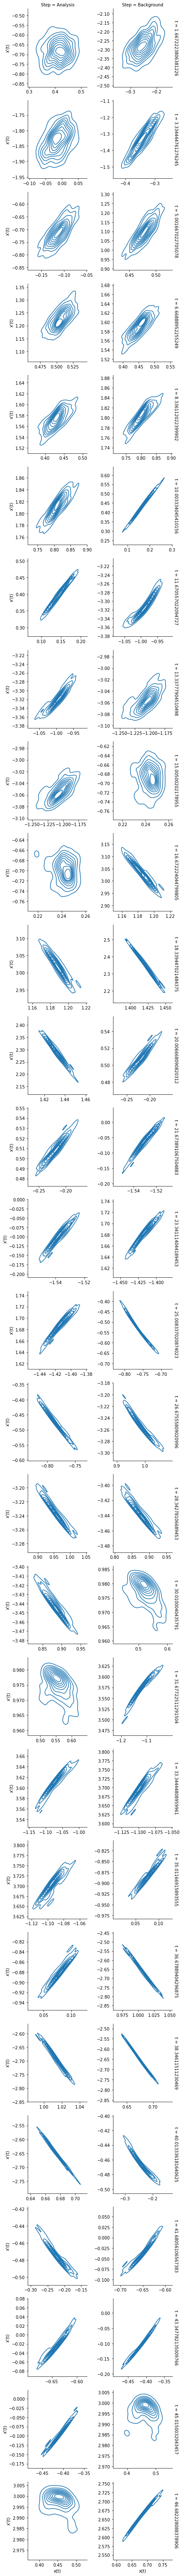

In [ ]:
g = sns.FacetGrid(df_data, col="Step",  row="t", sharex=False, sharey=False, margin_titles=True)
g.map(sns.kdeplot, 'x(t)', 'x\'(t)')